# Case Study - SABR and the Tariff Smile


## Introduction

A client buys a 1Y$\times$5Y **OTM payer swaption** (struck 100bp above ATM) from a dealer, seeking protection against a rate spike. The dealer delta-hedges the short position daily with the underlying 5Y swap.

We use the SABR model to analyze swaption smile dynamics during the `April 2025` tariff episode, calibrating to daily Bloomberg VCUB snapshots and testing the model’s ability to predict vol changes and improve hedging.

$$\Delta_{\text{SABR}} = \Delta_{\text{Black}} + \mathcal{V} \cdot \frac{\partial \sigma}{\partial F}$$


# Setup


In [16]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

In [17]:
from cmds.volskew import sabr, sabrATM, solve_alpha

# Data

**Daily smile snapshots (April 2025):**
* `../data/swaption_smile_daily_2025.xlsx` — Bloomberg VCUB, 1Y$\times$5Y, Black vol (%) at strike offsets
  - Sheet `black_vol_pct`: rows = dates, columns = bp offsets from ATM
  - Sheet `atm_forward`: VCUB forward rates (%)
  - Sheet `absolute_strikes_pct`: computed absolute strikes (%)

**Time series (March–May 2025):**
* `../data/swaption_vol_timeseries_2025.xlsx` — daily ATM swaption Black vols
* `../data/sofr_swaps.xlsx` — daily SOFR swap rates


In [18]:
DATAPATH = './data/'

# --- Daily smile snapshots (April 2025, 21 trading days) ---
smile_daily = pd.read_excel(DATAPATH + 'swaption_smile_daily_2025.xlsx',
                            sheet_name='black_vol_pct', index_col=0, parse_dates=True)
fwd_daily = pd.read_excel(DATAPATH + 'swaption_smile_daily_2025.xlsx',
                          sheet_name='atm_forward', index_col=0, parse_dates=True)

# --- Daily swap rates (pct -> decimal, March-May) ---
swaps_raw = pd.read_excel(DATAPATH + 'sofr_swaps.xlsx', sheet_name='data')
swaps_raw = swaps_raw.rename(columns={'Unnamed: 0': 'date'})
swaps_raw['date'] = pd.to_datetime(swaps_raw['date'])
swaps_raw = swaps_raw.set_index('date')
rate_5y = swaps_raw.loc['2025-03-01':'2025-05-31', 5.0] / 100

# --- Daily ATM swaption vols (bp, March-May) ---
vol_ts = pd.read_excel(DATAPATH + 'swaption_vol_timeseries_2025.xlsx',
                       sheet_name='atm_vols', index_col=0, parse_dates=True)
vol_1y5y = vol_ts.loc['2025-03-01':'2025-05-31', '1Yx5Y']

# Align broad time series
common_dates = rate_5y.index.intersection(vol_1y5y.index)
rate_5y = rate_5y.loc[common_dates]
vol_1y5y = vol_1y5y.loc[common_dates]

### Smile Snapshots

The daily smile data covers 21 trading days in April 2025. Below are a few representative curves showing the evolution before, during, and after the tariff shock.


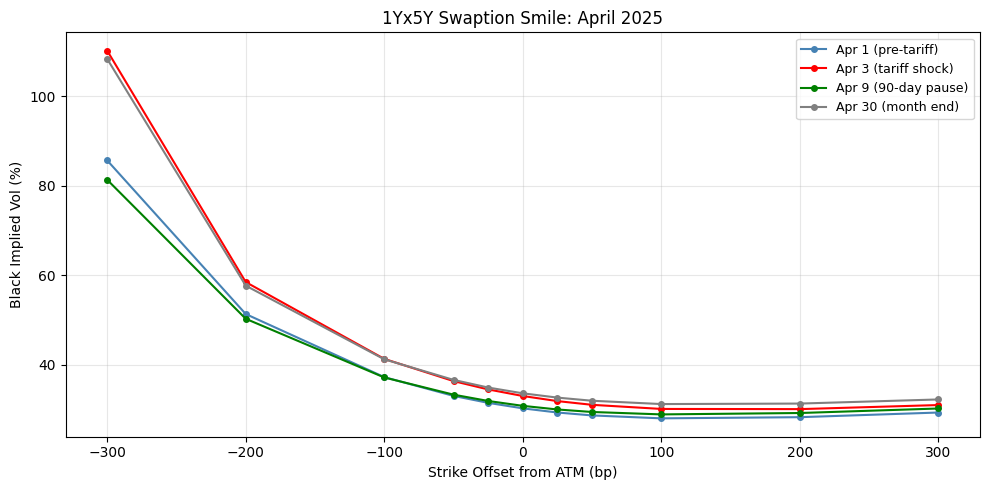

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

highlight_dates = ['2025-04-01', '2025-04-03', '2025-04-09', '2025-04-30']
colors = ['steelblue', 'red', 'green', 'gray']
labels = ['Apr 1 (pre-tariff)', 'Apr 3 (tariff shock)',
          'Apr 9 (90-day pause)', 'Apr 30 (month end)']

for dt_str, color, label in zip(highlight_dates, colors, labels):
    dt = pd.Timestamp(dt_str)
    if dt in smile_daily.index:
        offsets = smile_daily.columns.values.astype(int)
        vols = smile_daily.loc[dt].values
        ax.plot(offsets, vols, 'o-', color=color, label=label, markersize=4)

ax.set_xlabel('Strike Offset from ATM (bp)')
ax.set_ylabel('Black Implied Vol (%)')
ax.set_title('1Yx5Y Swaption Smile: April 2025')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Parameters


In [20]:
BETA = 0.5             # SABR beta
T_EXPIRY = 1.0         # 1Y option expiry
K_OFFSET = 0.01        # 100bp OTM payer
NOTIONAL = 100_000_000 # $100M notional
ANNUITY = 4.0          # approximate annuity factor
DOLLAR = NOTIONAL * ANNUITY
SHOCK = 1e-5           # finite-difference bump

CAL_OFFSETS = [-200, -100, -50, -25, 0, 25, 50, 100, 200]

### Market Context


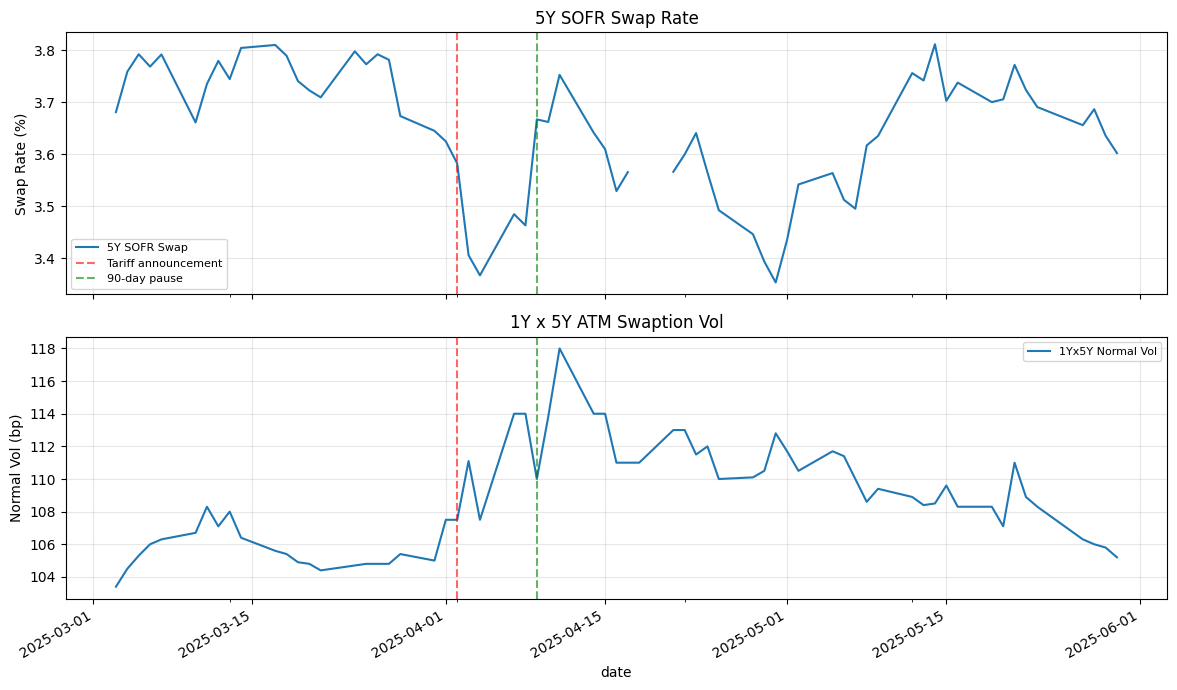

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax1 = axes[0]
(rate_5y * 100).plot(ax=ax1, label='5Y SOFR Swap')
ax1.axvline(pd.Timestamp('2025-04-02'), color='red', linestyle='--', alpha=0.6, label='Tariff announcement')
ax1.axvline(pd.Timestamp('2025-04-09'), color='green', linestyle='--', alpha=0.6, label='90-day pause')
ax1.set_ylabel('Swap Rate (%)')
ax1.set_title('5Y SOFR Swap Rate')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
vol_1y5y.plot(ax=ax2, label='1Yx5Y Normal Vol')
ax2.axvline(pd.Timestamp('2025-04-02'), color='red', linestyle='--', alpha=0.6)
ax2.axvline(pd.Timestamp('2025-04-09'), color='green', linestyle='--', alpha=0.6)
ax2.set_ylabel('Normal Vol (bp)')
ax2.set_title('1Y x 5Y ATM Swaption Vol')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 1. SABR Calibration


### 1.1.

Extract the 1Y$\times$5Y swaption smile from the `April 1` daily data (pre-tariff). Report the market Black implied vols for each strike offset.


In [22]:
# April 1 smile (pre-tariff)
dt0 = pd.Timestamp('2025-04-01')
F0 = fwd_daily.loc[dt0, 'atm_fwd_pct'] / 100  # decimal

offsets_all = smile_daily.columns.values.astype(int)
vols_apr1 = smile_daily.loc[dt0]

# Display
print(f'Forward rate on Apr 1: {F0*100:.2f}%\n')
print('Strike offset (bp) | Black vol (%)')
print('-' * 36)
for o in offsets_all:
    print(f'  {o:+4d}               | {vols_apr1[o]:.2f}')


Forward rate on Apr 1: 3.57%

Strike offset (bp) | Black vol (%)
------------------------------------
  -300               | 85.67
  -200               | 51.35
  -100               | 37.26
   -50               | 33.06
   -25               | 31.51
    +0               | 30.28
   +25               | 29.35
   +50               | 28.70
  +100               | 28.05
  +200               | 28.31
  +300               | 29.35


### 1.2.

Calibrate SABR with $\beta = 0.5$. Minimize the sum of squared vol errors over $(\nu, \rho)$, solving for $\alpha$ from the ATM constraint at each step.

Report the fitted parameters and overlay the model smile on the market data.


SABR Calibration (Apr 1, β=0.5):
  α = 0.0556
  ρ = -0.2613
  ν = 0.6833
  SSE = 0.000034


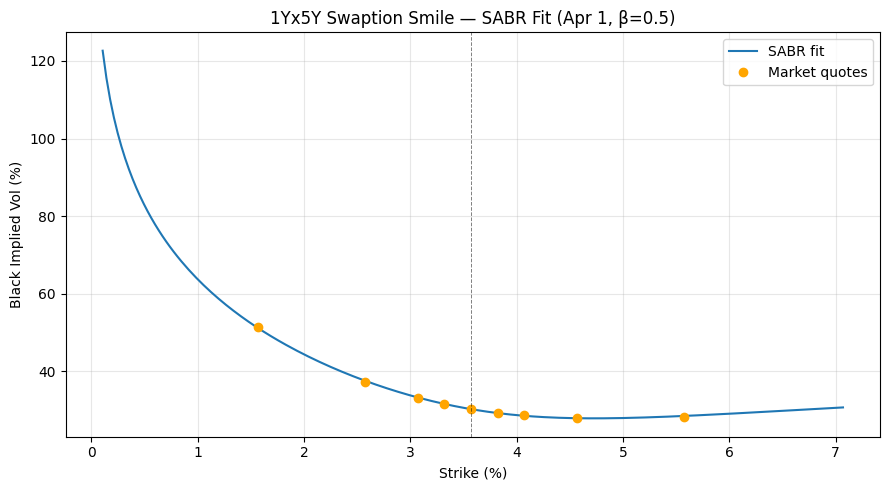

In [23]:
def calibrate_sabr(F, T, offsets, market_vols_pct, beta):
    """Calibrate SABR (alpha, rho, nu) using ATM-decoupled approach.
    market_vols_pct: array of Black vols in % at given bp offsets from ATM.
    Returns (alpha, rho, nu, sse).
    """
    strikes = F + np.array(offsets) / 10000
    mkt = np.array([market_vols_pct[o] for o in offsets]) / 100  # decimal
    sigma_atm = market_vols_pct[0] / 100  # offset 0

    def obj(params):
        rho, nu = params
        if nu <= 0 or rho <= -1 or rho >= 1:
            return 1e10
        a = solve_alpha(F, T, sigma_atm, beta, rho, nu)
        if a <= 0:
            return 1e10
        model = sabr(F, strikes, T, a, beta, rho, nu)
        return np.sum((model - mkt)**2)

    best = None; best_sse = 1e10
    for r0 in [-0.6, -0.3, 0.0, 0.3]:
        for n0 in [0.3, 0.6, 1.0, 1.5]:
            res = minimize(obj, [r0, n0], method='Nelder-Mead',
                          options={'maxiter': 50000, 'xatol': 1e-10, 'fatol': 1e-14})
            if res.fun < best_sse:
                best_sse = res.fun; best = res

    rho, nu = best.x
    alpha = solve_alpha(F, T, sigma_atm, beta, rho, nu)
    return alpha, rho, nu, best_sse

# Calibrate to April 1
cal_vols = smile_daily.loc[dt0][CAL_OFFSETS]
ALPHA0, RHO0, NU0, sse0 = calibrate_sabr(F0, T_EXPIRY, CAL_OFFSETS, cal_vols, BETA)

print(f'SABR Calibration (Apr 1, β={BETA}):')
print(f'  α = {ALPHA0:.4f}')
print(f'  ρ = {RHO0:.4f}')
print(f'  ν = {NU0:.4f}')
print(f'  SSE = {sse0:.6f}')

# Plot
strikes_cal = F0 + np.array(CAL_OFFSETS) / 10000
mkt_vols = np.array([cal_vols[o] for o in CAL_OFFSETS]) / 100

grid = np.linspace(F0 - 0.035, F0 + 0.035, 200)
grid = grid[grid > 0.001]
sabr_curve = sabr(F0, grid, T_EXPIRY, ALPHA0, BETA, RHO0, NU0)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(grid * 100, sabr_curve * 100, '-', label='SABR fit')
ax.plot(strikes_cal * 100, mkt_vols * 100, 'o', color='orange', label='Market quotes')
ax.axvline(F0 * 100, color='k', ls='--', lw=0.7, alpha=0.5)
ax.set_xlabel('Strike (%)')
ax.set_ylabel('Black Implied Vol (%)')
ax.set_title('1Yx5Y Swaption Smile — SABR Fit (Apr 1, β=0.5)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. The Backbone


### 2.1.

Compute the SABR ATM vol as a function of the forward rate, holding all parameters fixed. Plot the backbone.


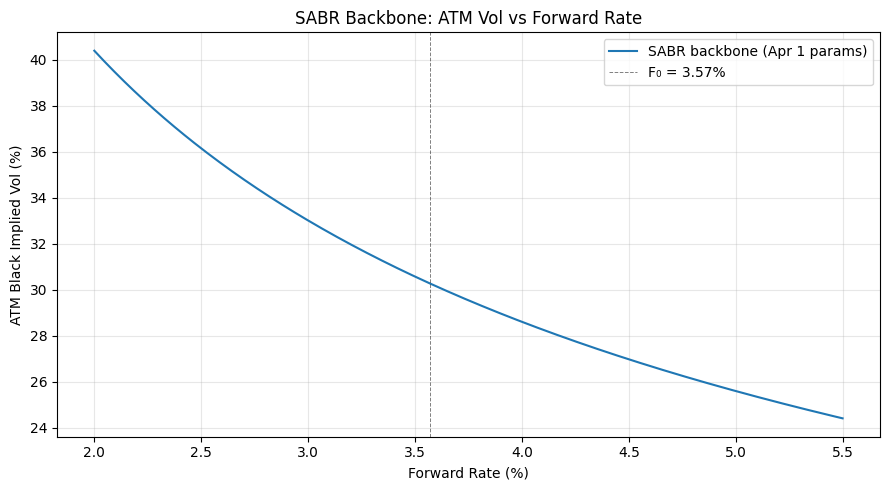

In [24]:
# SABR backbone: ATM vol as function of F, holding (alpha, beta, rho, nu) fixed at Apr 1 values
F_grid = np.linspace(0.020, 0.055, 300)
backbone_vols = np.array([sabrATM(f, T_EXPIRY, ALPHA0, BETA, RHO0, NU0) for f in F_grid])

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(F_grid * 100, backbone_vols * 100, '-', label='SABR backbone (Apr 1 params)')
ax.axvline(F0 * 100, color='k', ls='--', lw=0.7, alpha=0.5, label=f'F₀ = {F0*100:.2f}%')
ax.set_xlabel('Forward Rate (%)')
ax.set_ylabel('ATM Black Implied Vol (%)')
ax.set_title('SABR Backbone: ATM Vol vs Forward Rate')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2.

Overlay the daily observations of $(F_t, \sigma_{\text{ATM},t})$ from `April 2025` on the backbone.

Convert the normal vol timeseries to approximate Black vol using $\sigma_B \approx \sigma_N / F$.


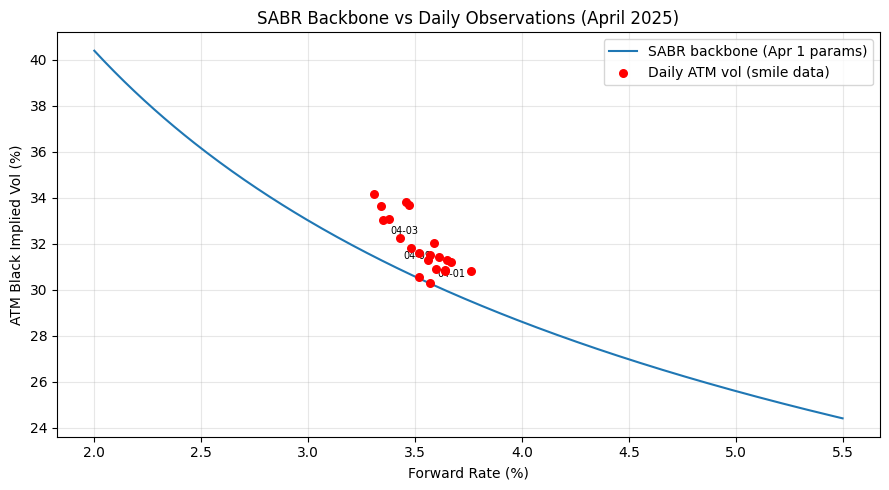

The backbone captures the general negative relationship between F and ATM vol
(negative rho), but daily observations deviate, especially during the tariff shock,
indicating that SABR params themselves shift over time.


In [25]:
# Daily observations: (F_t, sigma_ATM_t) from April
# Normal vol (bp) -> Black vol: sigma_B ≈ sigma_N / F
april_dates = smile_daily.index
F_april = fwd_daily.loc[april_dates, 'atm_fwd_pct'].values / 100

# Use the smile data directly for ATM Black vol (offset=0)
black_vol_april = smile_daily[0].values / 100  # already Black vol in %

# Also compute approximate Black vol from normal vol timeseries for comparison
# vol_1y5y is in bp of normal vol
april_mask = vol_1y5y.index.isin(april_dates)
if april_mask.sum() > 0:
    normal_vol_bp = vol_1y5y.loc[vol_1y5y.index.isin(april_dates)]
    F_for_norm = fwd_daily.loc[normal_vol_bp.index, 'atm_fwd_pct'].values / 100
    black_from_normal = (normal_vol_bp.values / 10000) / F_for_norm

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(F_grid * 100, backbone_vols * 100, '-', label='SABR backbone (Apr 1 params)')
ax.scatter(F_april * 100, black_vol_april * 100, c='red', zorder=5, s=30,
           label='Daily ATM vol (smile data)')
# Annotate a few key dates
for dt_str, offset in [('2025-04-01', (5, 5)), ('2025-04-03', (5, -10)), ('2025-04-09', (-30, 8))]:
    dt = pd.Timestamp(dt_str)
    if dt in april_dates:
        idx = list(april_dates).index(dt)
        ax.annotate(dt_str[5:], (F_april[idx]*100, black_vol_april[idx]*100),
                   textcoords='offset points', xytext=offset, fontsize=7)

ax.set_xlabel('Forward Rate (%)')
ax.set_ylabel('ATM Black Implied Vol (%)')
ax.set_title('SABR Backbone vs Daily Observations (April 2025)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('The backbone captures the general negative relationship between F and ATM vol')
print('(negative rho), but daily observations deviate, especially during the tariff shock,')
print('indicating that SABR params themselves shift over time.')

# 3. Augmented Delta


### 3.1.

Compute the Black delta and SABR augmented delta for the **OTM payer** ($K = F_0 + 100\text{bp}$) across a range of forward rates. Plot both, along with the correction.

$$\Delta_{\text{SABR}} = \Delta_{\text{Black}} + \mathcal{V}_{\text{Black}} \cdot \frac{\partial \sigma}{\partial F}$$

where $\frac{\partial \sigma}{\partial F}$ is computed by finite difference from the SABR formula.


/var/folders/x3/2h269p1576s293vgwkccn0zm0000gn/T/ipykernel_26101/1956367947.py:52: UserWarning: Glyph 119985 (\N{MATHEMATICAL SCRIPT CAPITAL V}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Fixed Income/Fixed-Income-Derivatives/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 119985 (\N{MATHEMATICAL SCRIPT CAPITAL V}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


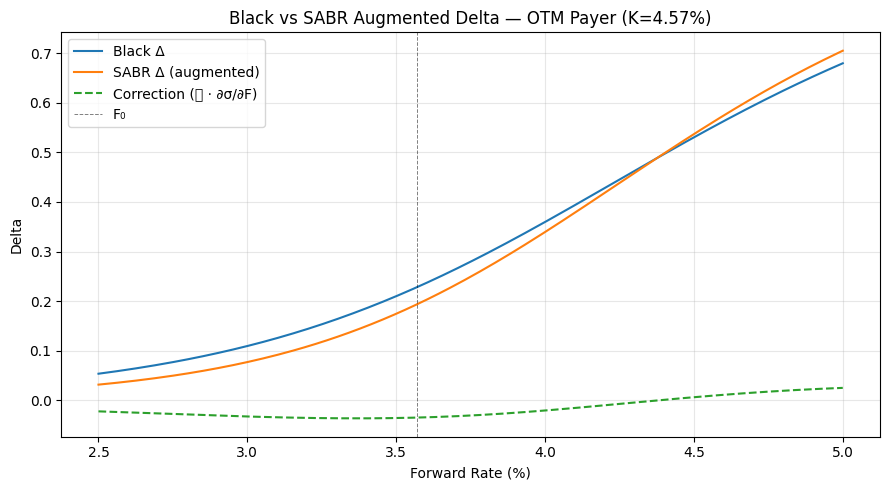

In [26]:
def black_call_price(F, K, T, sigma):
    """Black call price (undiscounted, per unit annuity)."""
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return F * norm.cdf(d1) - K * norm.cdf(d2)

def black_delta(F, K, T, sigma):
    """dC/dF from Black's formula."""
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def black_vega(F, K, T, sigma):
    """dC/dsigma from Black's formula."""
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return F * np.sqrt(T) * norm.pdf(d1)

def dsigma_dF(F, K, T, alpha, beta, rho, nu, h=SHOCK):
    """Finite-difference ∂σ/∂F from SABR."""
    s_up = sabr(F + h, K, T, alpha, beta, rho, nu)
    s_dn = sabr(F - h, K, T, alpha, beta, rho, nu)
    return (s_up - s_dn) / (2 * h)

# OTM payer strike: K = F0 + 100bp
K0 = F0 + K_OFFSET

# Compute deltas across a range of forward rates
F_range = np.linspace(0.025, 0.050, 200)
delta_black_arr = np.zeros(len(F_range))
delta_sabr_arr = np.zeros(len(F_range))
correction_arr = np.zeros(len(F_range))

for i, f in enumerate(F_range):
    sig = sabr(f, K0, T_EXPIRY, ALPHA0, BETA, RHO0, NU0)
    db = black_delta(f, K0, T_EXPIRY, sig)
    vg = black_vega(f, K0, T_EXPIRY, sig)
    dsdF = dsigma_dF(f, K0, T_EXPIRY, ALPHA0, BETA, RHO0, NU0)
    corr = vg * dsdF
    delta_black_arr[i] = db
    delta_sabr_arr[i] = db + corr
    correction_arr[i] = corr

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(F_range * 100, delta_black_arr, label='Black Δ')
ax.plot(F_range * 100, delta_sabr_arr, label='SABR Δ (augmented)')
ax.plot(F_range * 100, correction_arr, '--', label='Correction (𝒱 · ∂σ/∂F)')
ax.axvline(F0 * 100, color='k', ls='--', lw=0.7, alpha=0.5, label=f'F₀')
ax.set_xlabel('Forward Rate (%)')
ax.set_ylabel('Delta')
ax.set_title(f'Black vs SABR Augmented Delta — OTM Payer (K={K0*100:.2f}%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2.

Decompose the correction into its components: $\partial\sigma/\partial F$, vega, and their product. Report at the current forward and at $\pm$50bp.


In [27]:
# Decompose at F0, F0-50bp, F0+50bp
report_Fs = [F0 - 0.005, F0, F0 + 0.005]
labels = ['F₀ − 50bp', 'F₀ (ATM)', 'F₀ + 50bp']
rows = []
for f, lbl in zip(report_Fs, labels):
    sig = sabr(f, K0, T_EXPIRY, ALPHA0, BETA, RHO0, NU0)
    db = black_delta(f, K0, T_EXPIRY, sig)
    vg = black_vega(f, K0, T_EXPIRY, sig)
    dsdF_val = dsigma_dF(f, K0, T_EXPIRY, ALPHA0, BETA, RHO0, NU0)
    corr = vg * dsdF_val
    rows.append({
        'Forward': lbl,
        'σ_SABR': f'{sig*100:.2f}%',
        'Black Δ': f'{db:.4f}',
        'Vega': f'{vg:.6f}',
        '∂σ/∂F': f'{dsdF_val:.2f}',
        'Correction': f'{corr:.4f}',
        'SABR Δ': f'{db + corr:.4f}'
    })

display(pd.DataFrame(rows).set_index('Forward'))

,σ_SABR,Black Δ,Vega,∂σ/∂F,Correction,SABR Δ
Forward,,,,,,
F₀ − 50bp,30.10%,0.1207,0.006167,-5.43,-0.0335,0.0872
F₀ (ATM),27.94%,0.2284,0.010797,-3.20,-0.0345,0.1938
F₀ + 50bp,26.88%,0.3834,0.015538,-1.08,-0.0167,0.3666


# 4. Smile Dynamics


### 4.1.

Using the daily smile data loaded above, calibrate SABR ($\beta = 0.5$) to each day's smile.
Report the fitted parameters ($\alpha, \nu, \rho$) over time. How stable are $\nu$ and $\rho$?


In [28]:
print(f'Daily Smile Data: first 3 of {len(smile_daily)} trading days (Black vol %)')
display(smile_daily.head(3).round(2))
print('\nATM Forward Rates (%)')
display(fwd_daily.head(3).round(2))

Daily Smile Data: first 3 of 21 trading days (Black vol %)


,-300,-200,-100,-50,-25,0,25,50,100,200,300
date,,,,,,,,,,,
2025-04-01,85.67,51.35,37.26,33.06,31.51,30.28,29.35,28.70,28.05,28.31,29.35
2025-04-02,90.32,52.76,37.92,33.50,31.85,30.55,29.55,28.85,28.13,28.33,29.36
2025-04-03,110.18,58.49,41.33,36.37,34.51,33.04,31.90,31.07,30.15,30.11,31.02



ATM Forward Rates (%)


,atm_fwd_pct
date,
2025-04-01,3.57
2025-04-02,3.52
2025-04-03,3.35


,F,alpha,rho,nu,sse
date,,,,,
2025-04-01,0.0357,0.0556,-0.2613,0.6833,0.0000
2025-04-02,0.0352,0.0557,-0.2821,0.6933,0.0000
2025-04-03,0.0335,0.0588,-0.3022,0.7105,0.0001
2025-04-04,0.0331,0.0605,-0.3027,0.7111,0.0001
2025-04-07,0.0346,0.0611,-0.3026,0.7062,0.0000
2025-04-08,0.0347,0.0610,-0.2861,0.7026,0.0000
2025-04-09,0.0364,0.0571,-0.2127,0.6717,0.0000
2025-04-10,0.0367,0.0580,-0.2110,0.6696,0.0000
2025-04-11,0.0376,0.0580,-0.2084,0.6676,0.0000


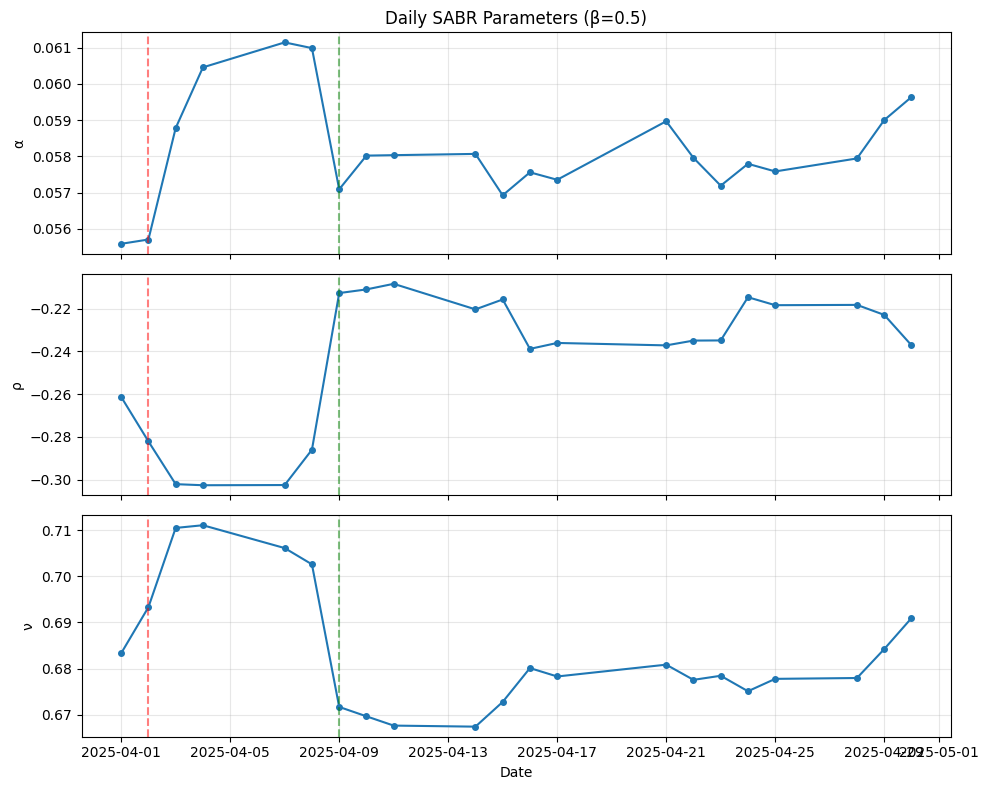

ν range: 0.667 – 0.711  (std=0.014)
ρ range: -0.303 – -0.208  (std=0.033)
ν and ρ shift noticeably during the tariff shock but are relatively stable otherwise.


In [29]:
# Daily SABR calibration across all April trading days
daily_params = []
for dt in smile_daily.index:
    F_t = fwd_daily.loc[dt, 'atm_fwd_pct'] / 100
    vols_t = smile_daily.loc[dt][CAL_OFFSETS]
    a, r, n, sse = calibrate_sabr(F_t, T_EXPIRY, CAL_OFFSETS, vols_t, BETA)
    daily_params.append({'date': dt, 'F': F_t, 'alpha': a, 'rho': r, 'nu': n, 'sse': sse})

params_df = pd.DataFrame(daily_params).set_index('date')

# Report
display(params_df.round(4))

# Plot parameter evolution
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for ax, col, lbl in zip(axes, ['alpha', 'rho', 'nu'], ['α', 'ρ', 'ν']):
    ax.plot(params_df.index, params_df[col], 'o-', markersize=4)
    ax.set_ylabel(lbl)
    ax.grid(True, alpha=0.3)
    ax.axvline(pd.Timestamp('2025-04-02'), color='red', ls='--', alpha=0.5)
    ax.axvline(pd.Timestamp('2025-04-09'), color='green', ls='--', alpha=0.5)
axes[0].set_title('Daily SABR Parameters (β=0.5)')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

print(f'ν range: {params_df["nu"].min():.3f} – {params_df["nu"].max():.3f}  (std={params_df["nu"].std():.3f})')
print(f'ρ range: {params_df["rho"].min():.3f} – {params_df["rho"].max():.3f}  (std={params_df["rho"].std():.3f})')
print('ν and ρ shift noticeably during the tariff shock but are relatively stable otherwise.')

### 4.2.

For each consecutive day, use the day-$t$ SABR backbone to predict the ATM vol at the day-$t{+}1$ forward rate. Compare to the actual next-day ATM vol.

Report the EOD vol, next-day vol, and SABR-predicted vol. How well does the backbone capture the vol dynamics?


In [30]:
# For each consecutive day pair, use day-t SABR backbone to predict day-(t+1) ATM vol
dates = smile_daily.index.tolist()
pred_rows = []
for i in range(len(dates) - 1):
    dt, dt1 = dates[i], dates[i + 1]
    F_t = fwd_daily.loc[dt, 'atm_fwd_pct'] / 100
    F_t1 = fwd_daily.loc[dt1, 'atm_fwd_pct'] / 100

    # Day-t params
    p = params_df.loc[dt]
    alpha_t, rho_t, nu_t = p['alpha'], p['rho'], p['nu']

    # Actual ATM vols
    vol_t = smile_daily.loc[dt, 0] / 100
    vol_t1_actual = smile_daily.loc[dt1, 0] / 100

    # SABR backbone prediction: ATM vol at F_{t+1} using day-t params
    vol_t1_pred = sabrATM(F_t1, T_EXPIRY, alpha_t, BETA, rho_t, nu_t)

    pred_rows.append({
        'date_t': dt.strftime('%m/%d'),
        'date_t1': dt1.strftime('%m/%d'),
        'F_t (%)': F_t * 100,
        'F_t+1 (%)': F_t1 * 100,
        'σ_t (%)': vol_t * 100,
        'σ_t+1 actual (%)': vol_t1_actual * 100,
        'σ_t+1 SABR (%)': vol_t1_pred * 100,
        'error (bp)': (vol_t1_pred - vol_t1_actual) * 10000
    })

pred_df = pd.DataFrame(pred_rows)
display(pred_df.round(2))

rmse_bp = np.sqrt(np.mean(pred_df['error (bp)']**2))
print(f'\nBackbone prediction RMSE: {rmse_bp:.1f} bp')
print('The backbone captures direction (vol rises when F falls) but undershoots')
print('large moves, since it holds ν and ρ fixed while the market reshapes the smile.')

,date_t,date_t1,F_t (%),F_t+1 (%),σ_t (%),σ_t+1 actual (%),σ_t+1 SABR (%),error (bp)
0,04/01,04/02,3.57,3.52,30.28,30.55,30.49,-5.67
1,04/02,04/03,3.52,3.35,30.55,33.04,31.31,-172.86
2,04/03,04/04,3.35,3.31,33.04,34.18,33.24,-94.22
3,04/04,04/07,3.31,3.46,34.18,33.80,33.44,-36.44
4,04/07,04/08,3.46,3.47,33.80,33.69,33.75,6.16
5,04/08,04/09,3.47,3.64,33.69,30.84,32.90,205.84
6,04/09,04/10,3.64,3.67,30.84,31.21,30.71,-49.59
7,04/10,04/11,3.67,3.76,31.21,30.84,30.84,-0.45
8,04/11,04/14,3.76,3.65,30.84,31.30,31.30,-0.02
9,04/14,04/15,3.65,3.60,31.30,30.92,31.52,59.58



Backbone prediction RMSE: 73.8 bp
The backbone captures direction (vol rises when F falls) but undershoots
large moves, since it holds ν and ρ fixed while the market reshapes the smile.


### 4.3.

For the two key event days — `April 2→3` (tariff shock) and `April 8→9` (90-day pause) — test whether SABR correctly predicts the *shape* of the next-day smile.

At the same **absolute strikes** as day $t$:
* **Black** assumes the smile is unchanged.
* **SABR** uses the day-$t$ calibration ($\nu, \rho$), the actual day-$t{+}1$ ATM vol, and re-solves $\alpha$.

Plot all three curves (day $t$, SABR predicted, day $t{+}1$ actual). Report RMSE across all day-pairs.


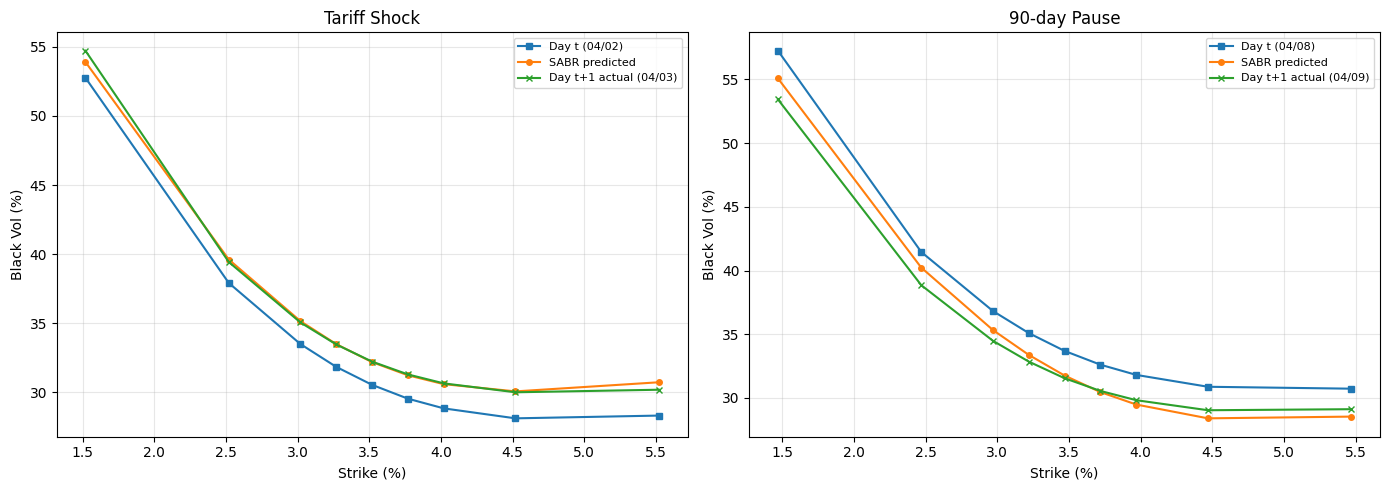

,Black RMSE (bp),SABR RMSE (bp)
Event,,
Tariff Shock,174.5,33.5
90-day Pause,237.0,85.1


SABR (re-calibrating α to the new ATM vol) predicts the smile shape better than
the flat Black assumption, especially during large rate moves.


In [31]:
# Event day pairs: Apr 2→3 (tariff shock), Apr 8→9 (90-day pause)
event_pairs = [
    (pd.Timestamp('2025-04-02'), pd.Timestamp('2025-04-03'), 'Tariff Shock'),
    (pd.Timestamp('2025-04-08'), pd.Timestamp('2025-04-09'), '90-day Pause'),
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
all_rmse = []

for ax, (dt, dt1, title) in zip(axes, event_pairs):
    F_t = fwd_daily.loc[dt, 'atm_fwd_pct'] / 100
    F_t1 = fwd_daily.loc[dt1, 'atm_fwd_pct'] / 100
    p = params_df.loc[dt]
    alpha_t, rho_t, nu_t = p['alpha'], p['rho'], p['nu']

    # Absolute strikes from day t
    abs_strikes = F_t + np.array(CAL_OFFSETS) / 10000

    # Day-t actual smile
    vols_t = np.array([smile_daily.loc[dt, o] for o in CAL_OFFSETS]) / 100

    # Day-t+1 actual smile (at same absolute strikes, interpolated from offset smile)
    # We need day-t+1 vols at the day-t absolute strikes
    # Day-t+1 offsets for these strikes: (abs_strikes - F_t1) * 10000
    offsets_t1 = (abs_strikes - F_t1) * 10000
    # Actual day-t+1 vols at their own offsets
    vols_t1_actual_at_offsets = np.array([smile_daily.loc[dt1, o] for o in CAL_OFFSETS]) / 100
    abs_strikes_t1 = F_t1 + np.array(CAL_OFFSETS) / 10000

    # Black prediction: same vol at same absolute strikes (flat, no change)
    vols_black_pred = vols_t  # unchanged

    # SABR prediction: use day-t (rho, nu), day-t+1 actual ATM vol, re-solve alpha
    sigma_atm_t1 = smile_daily.loc[dt1, 0] / 100
    alpha_pred = solve_alpha(F_t1, T_EXPIRY, sigma_atm_t1, BETA, rho_t, nu_t)
    vols_sabr_pred = sabr(F_t1, abs_strikes, T_EXPIRY, alpha_pred, BETA, rho_t, nu_t)

    # Actual day-t+1 vols at the day-t absolute strikes (interpolate from day-t+1 smile)
    from scipy.interpolate import interp1d
    interp_func = interp1d(abs_strikes_t1, vols_t1_actual_at_offsets,
                           kind='cubic', fill_value='extrapolate')
    vols_t1_at_t_strikes = interp_func(abs_strikes)

    # RMSE
    rmse_black = np.sqrt(np.mean((vols_black_pred - vols_t1_at_t_strikes)**2)) * 10000
    rmse_sabr = np.sqrt(np.mean((vols_sabr_pred - vols_t1_at_t_strikes)**2)) * 10000
    all_rmse.append({'Event': title, 'Black RMSE (bp)': rmse_black, 'SABR RMSE (bp)': rmse_sabr})

    ax.plot(abs_strikes * 100, vols_t * 100, 's-', markersize=4, label=f'Day t ({dt.strftime("%m/%d")})')
    ax.plot(abs_strikes * 100, vols_sabr_pred * 100, 'o-', markersize=4, label='SABR predicted')
    ax.plot(abs_strikes * 100, vols_t1_at_t_strikes * 100, 'x-', markersize=5,
            label=f'Day t+1 actual ({dt1.strftime("%m/%d")})')
    ax.set_xlabel('Strike (%)')
    ax.set_ylabel('Black Vol (%)')
    ax.set_title(title)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

display(pd.DataFrame(all_rmse).set_index('Event').round(1))
print('SABR (re-calibrating α to the new ATM vol) predicts the smile shape better than')
print('the flat Black assumption, especially during large rate moves.')

# 5. Hedging Simulation (Extension)


### 5.1.

Using the `April` daily data, simulate a daily delta hedge of the OTM payer swaption ($K = F_0 + 100\text{bp}$) using the `April 1` calibration ($\nu, \rho$), re-solving $\alpha$ daily.

Plot the daily hedging error $\varepsilon_t = \Delta_{t-1} \cdot \Delta F_t - \Delta V_t$ for both Black and SABR delta. Report summary statistics.


### 5.2.

Repeat with an **ATM strike**. Compare the hedging error reduction at ATM vs OTM.
